## XGB per-Tissue training and model evaluation

#### Required package

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from pathlib import Path
from os import listdir
import sklearn.model_selection
import sklearn.feature_selection
%matplotlib inline
sns.set_style("whitegrid")

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn import metrics #Additional scklearn functions

### Supporting functions

In [7]:
def predOneTissue(alg, dtrain,y_train, useTrainCV=True, cvFolds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        extra = {'num_class': len(y_train.unique())}
        xgbParams = alg.get_xgb_params()
        xgbParams.update(extra)
        xgTrain = xgb.DMatrix(dtrain, label=y_train)
        cvresult = xgb.cv(xgbParams,
                      xgTrain,
                      num_boost_round=alg.get_params()['n_estimators'],
                      nfold=cvFolds,
                      stratified=True,
                      metrics={'mlogloss'},
                      early_stopping_rounds=early_stopping_rounds,
                      seed=0,
                      callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                                 xgb.callback.early_stop(3)])

        #print(cvresult)
        alg.set_params(n_estimators=cvresult.shape[0])
    alg.set_params(num_class=len(y_train.unique()))
    #Fit alg
    print(dtrain.shape,y_train.shape)
    alg.fit(dtrain,y_train,eval_metric='auc')
    return alg
def scoreOneTissue(y_test,y_preds):
    """
    Returns a tuple of raw score and F1.
    """
    return (metrics.accuracy_score(y_test,y_preds))
def splitData(X,y,rng=1234):
    return sklearn.model_selection.train_test_split(X, y, test_size=.3, random_state=rng)
def simpleExpressionFilter(counts,min_count):
    """accepts raw counts and a minimum sum count per gene across all samples
    return a boolean array of all genes, which can be applied to any transformed counts.
    True is associated with passing the test.
    """
    keep=np.sum(counts)>min_count
    #print("Pre",counts.shape[1])
    #filtered_counts=counts.loc[:,(keep)] # similar to how the boolean array would be used on any count matrix
    #print("Post",filtered_counts.shape[1])
    return(keep)
def loadData(TISSUE,data_dir,tissue_dir):
    cpm=pd.read_csv(data_dir/tissue_dir/str(TISSUE+"_cpm.tsv"),sep="\t",index_col=0)
    #lcpm=pd.read_csv(data_dir/tissue_dir/str(TISSUE+"_lcpm.tsv"),sep="\t",index_col=0)
    cdat=pd.read_csv(data_dir/tissue_dir/str(TISSUE+"_c.tsv"),sep="\t",index_col=0)
    return (cpm,cdat)

### Preparing metadata

In [9]:
data_dir=Path("data")
tissue_dir=Path("tissue-specific")
manifest={"data":"All_Tissue_Site_Details.combined.reads.gct",
              "sample_meta":"GTEx_v7_Annotations_SampleAttributesDS.txt",
              "subject_meta":"GTEx_v7_Annotations_SubjectPhenotypesDS.txt",
               "merged_meta":"merged_meta.tsv"}
meta=pd.read_csv(data_dir/manifest['merged_meta'],sep="\t",dtype={'SMUBRID':object,'SEX':object,'DTHHRDY':object})
meta=meta[~(meta['AGE'].isnull())]
counts=pd.DataFrame(meta['SMTS'].value_counts())
df=meta[meta['SMTS'].isin(counts[counts['SMTS']>200].index)]

### Main Loop

In [ ]:
def mainLoop(df,data_dir,tissue_dir):
    data_dir=Path("data")
    tissue_dir=Path("tissue-specific")
    results=[]
    algs=[]
    TISSUE_list=df['SMTS'].unique()
    for TISSUE in TISSUE_list:
        cpm,cdat=loadData(TISSUE,data_dir,tissue_dir)
        #print(cpm.shape)
        #print(cdat.shape)
        all_age=df.loc[(df['SMTS']==TISSUE),'AGE']
        #print(all_age.shape)
        cpm_train,cpm_test,y_train,y_test=splitData(cpm,all_age)
        c_train,c_test,y_train,y_test=splitData(cdat,all_age)
        #y_train.map({'20-29':0,'30-39':1,'40-49':2,'50-59':3, '60-69':4,'70-79':5})
        #y_test.map({'20-29':0,'30-39':1,'40-49':2,'50-59':3, '60-69':4,'70-79':5})
        y_train.replace({"20-29":0, "30-39":1, "40-49":2, "50-59":3, "60-69":4, "70-79":5}, inplace = True)
        y_test.replace({"20-29":0, "30-39":1, "40-49":2, "50-59":3, "60-69":4, "70-79":5}, inplace = True)
        #print(y_train.shape)
        #print(cpm_train.shape)
        #print(c_train.shape)
        keep=simpleExpressionFilter(c_train,10)
        cpm_train=cpm_train.loc[:,(keep)]
        cpm_test=cpm_test.loc[:,(keep)]
        
        selector=sklearn.feature_selection.VarianceThreshold(threshold=.1)
        selector.fit(cpm_train)
        keep=selector.get_support(indices=True)
        cpm_train=cpm_train.iloc[:,keep]
        cpm_test=cpm_test.iloc[:,keep]
        
        xgb1 = XGBClassifier(
         learning_rate =0.1,
         n_estimators=1000,
         max_depth=5,
         min_child_weight=1,
         gamma=0,
         subsample=0.8,
         colsample_bytree=0.8,
         objective= 'multi:softprob',
         nthread=30,
         scale_pos_weight=1,
         seed=1234)
        xgb1=predOneTissue(xgb1,cpm_train,y_train)
        y_preds=xgb1.predict(cpm_test)
        score=scoreOneTissue(y_test,y_preds)
        #print(y_test,y_preds)
        results.append(score)
        algs.append(xgb1)
    results=pd.Series(results,index=TISSUE_list)
    return (algs,results)

### Generating Models

In [12]:
algs,results=mainLoop(df,data_dir,tissue_dir)

/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-mlogloss:1.62723	test-mlogloss:1.75625
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 3 rounds.
[1]	train-mlogloss:1.49117	test-mlogloss:1.71253
[2]	train-mlogloss:1.37144	test-mlogloss:1.68676
[3]	train-mlogloss:1.26631	test-mlogloss:1.65759
[4]	train-mlogloss:1.17219	test-mlogloss:1.63195
[5]	train-mlogloss:1.08398	test-mlogloss:1.61364
[6]	train-mlogloss:1.00558	test-mlogloss:1.59863
[7]	train-mlogloss:0.936582	test-mlogloss:1.57958
[8]	train-mlogloss:0.872804	test-mlogloss:1.56196
[9]	train-mlogloss:0.816358	test-mlogloss:1.54551
[10]	train-mlogloss:0.763223	test-mlogloss:1.53085
[11]	train-mlogloss:0.715494	test-mlogloss:1.51898
[12]	train-mlogloss:0.670301	test-mlogloss:1.50313
[13]	train-mlogloss:0.62889	test-mlogloss:1.4951
[14]	train-mlogloss:0.589712	test-mlogloss:1.48627
[15]	train-mlogloss:0.553587	test-mlogloss:1.48002
[16]	train-mlogloss:0.521056	test-mlogloss:1.47262
[1

/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-mlogloss:1.6308	test-mlogloss:1.74831
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 3 rounds.
[1]	train-mlogloss:1.49492	test-mlogloss:1.70418
[2]	train-mlogloss:1.37817	test-mlogloss:1.66758
[3]	train-mlogloss:1.27171	test-mlogloss:1.63753
[4]	train-mlogloss:1.17936	test-mlogloss:1.61212
[5]	train-mlogloss:1.09242	test-mlogloss:1.58946
[6]	train-mlogloss:1.01204	test-mlogloss:1.56559
[7]	train-mlogloss:0.943112	test-mlogloss:1.54294
[8]	train-mlogloss:0.879043	test-mlogloss:1.52504
[9]	train-mlogloss:0.820085	test-mlogloss:1.50941
[10]	train-mlogloss:0.766329	test-mlogloss:1.49194
[11]	train-mlogloss:0.716385	test-mlogloss:1.4783
[12]	train-mlogloss:0.6714	test-mlogloss:1.46358
[13]	train-mlogloss:0.629	test-mlogloss:1.45327
[14]	train-mlogloss:0.590004	test-mlogloss:1.44447
[15]	train-mlogloss:0.555076	test-mlogloss:1.43161
[16]	train-mlogloss:0.522489	test-mlogloss:1.42111
[17]	tr

/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-mlogloss:1.60869	test-mlogloss:1.73007
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 3 rounds.
[1]	train-mlogloss:1.45709	test-mlogloss:1.68186
[2]	train-mlogloss:1.32824	test-mlogloss:1.64892
[3]	train-mlogloss:1.21237	test-mlogloss:1.60797
[4]	train-mlogloss:1.11179	test-mlogloss:1.578
[5]	train-mlogloss:1.02635	test-mlogloss:1.55
[6]	train-mlogloss:0.945054	test-mlogloss:1.5256
[7]	train-mlogloss:0.873949	test-mlogloss:1.50352
[8]	train-mlogloss:0.809525	test-mlogloss:1.48985
[9]	train-mlogloss:0.751001	test-mlogloss:1.46971
[10]	train-mlogloss:0.697382	test-mlogloss:1.45134
[11]	train-mlogloss:0.649128	test-mlogloss:1.43551
[12]	train-mlogloss:0.603495	test-mlogloss:1.4226
[13]	train-mlogloss:0.56239	test-mlogloss:1.41392
[14]	train-mlogloss:0.52452	test-mlogloss:1.40615
[15]	train-mlogloss:0.489726	test-mlogloss:1.39553
[16]	train-mlogloss:0.45799	test-mlogloss:1.38812
[17]	trai

/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-mlogloss:1.62458	test-mlogloss:1.7603
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 3 rounds.
[1]	train-mlogloss:1.48475	test-mlogloss:1.75029
[2]	train-mlogloss:1.35653	test-mlogloss:1.73464
[3]	train-mlogloss:1.24572	test-mlogloss:1.72469
[4]	train-mlogloss:1.1469	test-mlogloss:1.71252
[5]	train-mlogloss:1.05638	test-mlogloss:1.71053
[6]	train-mlogloss:0.977475	test-mlogloss:1.69693
[7]	train-mlogloss:0.904182	test-mlogloss:1.68281
[8]	train-mlogloss:0.839464	test-mlogloss:1.67911
[9]	train-mlogloss:0.780184	test-mlogloss:1.67069
[10]	train-mlogloss:0.725435	test-mlogloss:1.66413
[11]	train-mlogloss:0.676193	test-mlogloss:1.66201
[12]	train-mlogloss:0.629202	test-mlogloss:1.66187
[13]	train-mlogloss:0.588011	test-mlogloss:1.65833
[14]	train-mlogloss:0.549467	test-mlogloss:1.65554
[15]	train-mlogloss:0.513601	test-mlogloss:1.65407
[16]	train-mlogloss:0.480563	test-mlogloss:1.65677
[

/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-mlogloss:1.64027	test-mlogloss:1.76577
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 3 rounds.
[1]	train-mlogloss:1.4993	test-mlogloss:1.74103
[2]	train-mlogloss:1.38147	test-mlogloss:1.72017
[3]	train-mlogloss:1.27506	test-mlogloss:1.70215
[4]	train-mlogloss:1.17606	test-mlogloss:1.6904
[5]	train-mlogloss:1.08882	test-mlogloss:1.67612
[6]	train-mlogloss:1.01018	test-mlogloss:1.6666
[7]	train-mlogloss:0.938717	test-mlogloss:1.65965
[8]	train-mlogloss:0.870944	test-mlogloss:1.64999
[9]	train-mlogloss:0.812613	test-mlogloss:1.64066
[10]	train-mlogloss:0.758909	test-mlogloss:1.63313
[11]	train-mlogloss:0.708976	test-mlogloss:1.62378
[12]	train-mlogloss:0.663855	test-mlogloss:1.61797
[13]	train-mlogloss:0.623118	test-mlogloss:1.6103
[14]	train-mlogloss:0.584143	test-mlogloss:1.60018
[15]	train-mlogloss:0.548921	test-mlogloss:1.59729
[16]	train-mlogloss:0.516251	test-mlogloss:1.5943
[17]	

/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-mlogloss:1.65942	test-mlogloss:1.7606
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 3 rounds.
[1]	train-mlogloss:1.5461	test-mlogloss:1.73419
[2]	train-mlogloss:1.44427	test-mlogloss:1.71035
[3]	train-mlogloss:1.34472	test-mlogloss:1.68839
[4]	train-mlogloss:1.25756	test-mlogloss:1.67214
[5]	train-mlogloss:1.18018	test-mlogloss:1.65544
[6]	train-mlogloss:1.10842	test-mlogloss:1.6387
[7]	train-mlogloss:1.0411	test-mlogloss:1.62583
[8]	train-mlogloss:0.979213	test-mlogloss:1.61107
[9]	train-mlogloss:0.922133	test-mlogloss:1.60064
[10]	train-mlogloss:0.867716	test-mlogloss:1.59166
[11]	train-mlogloss:0.818085	test-mlogloss:1.58238
[12]	train-mlogloss:0.772857	test-mlogloss:1.57112
[13]	train-mlogloss:0.729558	test-mlogloss:1.56237
[14]	train-mlogloss:0.690405	test-mlogloss:1.55529
[15]	train-mlogloss:0.654781	test-mlogloss:1.5493
[16]	train-mlogloss:0.619542	test-mlogloss:1.54388
[17]	t

/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-mlogloss:1.63103	test-mlogloss:1.75599
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 3 rounds.
[1]	train-mlogloss:1.48559	test-mlogloss:1.71649
[2]	train-mlogloss:1.36021	test-mlogloss:1.69182
[3]	train-mlogloss:1.24793	test-mlogloss:1.66629
[4]	train-mlogloss:1.14974	test-mlogloss:1.64098
[5]	train-mlogloss:1.05818	test-mlogloss:1.62059
[6]	train-mlogloss:0.978814	test-mlogloss:1.60472
[7]	train-mlogloss:0.907214	test-mlogloss:1.58399
[8]	train-mlogloss:0.839631	test-mlogloss:1.5727
[9]	train-mlogloss:0.778291	test-mlogloss:1.56026
[10]	train-mlogloss:0.725874	test-mlogloss:1.54591
[11]	train-mlogloss:0.677309	test-mlogloss:1.53461
[12]	train-mlogloss:0.630819	test-mlogloss:1.52624
[13]	train-mlogloss:0.589918	test-mlogloss:1.5181
[14]	train-mlogloss:0.551226	test-mlogloss:1.50802
[15]	train-mlogloss:0.516764	test-mlogloss:1.50194
[16]	train-mlogloss:0.484652	test-mlogloss:1.50153
[

/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-mlogloss:1.64576	test-mlogloss:1.75233
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 3 rounds.
[1]	train-mlogloss:1.51872	test-mlogloss:1.71793
[2]	train-mlogloss:1.40329	test-mlogloss:1.68776
[3]	train-mlogloss:1.2978	test-mlogloss:1.66108
[4]	train-mlogloss:1.20616	test-mlogloss:1.64237
[5]	train-mlogloss:1.12177	test-mlogloss:1.62323
[6]	train-mlogloss:1.04434	test-mlogloss:1.60632
[7]	train-mlogloss:0.974897	test-mlogloss:1.58708
[8]	train-mlogloss:0.911448	test-mlogloss:1.57222
[9]	train-mlogloss:0.854488	test-mlogloss:1.5573
[10]	train-mlogloss:0.802543	test-mlogloss:1.54635
[11]	train-mlogloss:0.753999	test-mlogloss:1.53584
[12]	train-mlogloss:0.707438	test-mlogloss:1.52743
[13]	train-mlogloss:0.663252	test-mlogloss:1.51648
[14]	train-mlogloss:0.624073	test-mlogloss:1.5074
[15]	train-mlogloss:0.587505	test-mlogloss:1.49742
[16]	train-mlogloss:0.554091	test-mlogloss:1.4914
[17]

/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-mlogloss:1.62562	test-mlogloss:1.73792
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 3 rounds.
[1]	train-mlogloss:1.48387	test-mlogloss:1.69874
[2]	train-mlogloss:1.36229	test-mlogloss:1.66588
[3]	train-mlogloss:1.25312	test-mlogloss:1.63387
[4]	train-mlogloss:1.15503	test-mlogloss:1.60495
[5]	train-mlogloss:1.06851	test-mlogloss:1.5855
[6]	train-mlogloss:0.989282	test-mlogloss:1.56055
[7]	train-mlogloss:0.916157	test-mlogloss:1.54497
[8]	train-mlogloss:0.851742	test-mlogloss:1.53047
[9]	train-mlogloss:0.791991	test-mlogloss:1.5184
[10]	train-mlogloss:0.739237	test-mlogloss:1.50638
[11]	train-mlogloss:0.690256	test-mlogloss:1.493
[12]	train-mlogloss:0.645892	test-mlogloss:1.48141
[13]	train-mlogloss:0.603253	test-mlogloss:1.47381
[14]	train-mlogloss:0.566304	test-mlogloss:1.46186
[15]	train-mlogloss:0.530764	test-mlogloss:1.45148
[16]	train-mlogloss:0.497048	test-mlogloss:1.44029
[17

/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-mlogloss:1.62618	test-mlogloss:1.75689
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 3 rounds.
[1]	train-mlogloss:1.48062	test-mlogloss:1.72226
[2]	train-mlogloss:1.35458	test-mlogloss:1.6985
[3]	train-mlogloss:1.244	test-mlogloss:1.66294
[4]	train-mlogloss:1.14643	test-mlogloss:1.64615
[5]	train-mlogloss:1.05598	test-mlogloss:1.62481
[6]	train-mlogloss:0.976105	test-mlogloss:1.60881
[7]	train-mlogloss:0.904506	test-mlogloss:1.59394
[8]	train-mlogloss:0.838625	test-mlogloss:1.58139
[9]	train-mlogloss:0.778943	test-mlogloss:1.56729
[10]	train-mlogloss:0.724447	test-mlogloss:1.55246
[11]	train-mlogloss:0.675468	test-mlogloss:1.54068
[12]	train-mlogloss:0.63141	test-mlogloss:1.52983
[13]	train-mlogloss:0.590379	test-mlogloss:1.52442
[14]	train-mlogloss:0.552812	test-mlogloss:1.51944
[15]	train-mlogloss:0.517025	test-mlogloss:1.51271
[16]	train-mlogloss:0.485194	test-mlogloss:1.50755
[17

/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-mlogloss:1.63412	test-mlogloss:1.75296
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 3 rounds.
[1]	train-mlogloss:1.48764	test-mlogloss:1.72757
[2]	train-mlogloss:1.36419	test-mlogloss:1.70735
[3]	train-mlogloss:1.24985	test-mlogloss:1.68651
[4]	train-mlogloss:1.1527	test-mlogloss:1.66528
[5]	train-mlogloss:1.06616	test-mlogloss:1.64322
[6]	train-mlogloss:0.98735	test-mlogloss:1.6318
[7]	train-mlogloss:0.914975	test-mlogloss:1.62502
[8]	train-mlogloss:0.85056	test-mlogloss:1.61506
[9]	train-mlogloss:0.79159	test-mlogloss:1.6042
[10]	train-mlogloss:0.738907	test-mlogloss:1.59265
[11]	train-mlogloss:0.689431	test-mlogloss:1.58432
[12]	train-mlogloss:0.645034	test-mlogloss:1.57394
[13]	train-mlogloss:0.602468	test-mlogloss:1.56765
[14]	train-mlogloss:0.564137	test-mlogloss:1.56108
[15]	train-mlogloss:0.527829	test-mlogloss:1.55526
[16]	train-mlogloss:0.494761	test-mlogloss:1.55028
[17]	

/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-mlogloss:1.62888	test-mlogloss:1.7531
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 3 rounds.
[1]	train-mlogloss:1.48053	test-mlogloss:1.71451
[2]	train-mlogloss:1.35068	test-mlogloss:1.68514
[3]	train-mlogloss:1.23839	test-mlogloss:1.67023
[4]	train-mlogloss:1.13999	test-mlogloss:1.6503
[5]	train-mlogloss:1.04986	test-mlogloss:1.62632
[6]	train-mlogloss:0.968941	test-mlogloss:1.60814
[7]	train-mlogloss:0.898351	test-mlogloss:1.59219
[8]	train-mlogloss:0.831274	test-mlogloss:1.57617
[9]	train-mlogloss:0.774062	test-mlogloss:1.56629
[10]	train-mlogloss:0.721827	test-mlogloss:1.55429
[11]	train-mlogloss:0.67243	test-mlogloss:1.5396
[12]	train-mlogloss:0.627102	test-mlogloss:1.52808
[13]	train-mlogloss:0.585868	test-mlogloss:1.51681
[14]	train-mlogloss:0.548043	test-mlogloss:1.50622
[15]	train-mlogloss:0.513316	test-mlogloss:1.49849
[16]	train-mlogloss:0.480779	test-mlogloss:1.48679
[17

/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0]	train-mlogloss:1.626	test-mlogloss:1.74589
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 3 rounds.
[1]	train-mlogloss:1.48256	test-mlogloss:1.71312
[2]	train-mlogloss:1.35581	test-mlogloss:1.67524
[3]	train-mlogloss:1.24284	test-mlogloss:1.65572
[4]	train-mlogloss:1.14492	test-mlogloss:1.63376
[5]	train-mlogloss:1.05554	test-mlogloss:1.60612
[6]	train-mlogloss:0.973133	test-mlogloss:1.58753
[7]	train-mlogloss:0.897811	test-mlogloss:1.57089
[8]	train-mlogloss:0.830102	test-mlogloss:1.55741
[9]	train-mlogloss:0.769675	test-mlogloss:1.53544
[10]	train-mlogloss:0.714516	test-mlogloss:1.52551
[11]	train-mlogloss:0.665267	test-mlogloss:1.51696
[12]	train-mlogloss:0.619384	test-mlogloss:1.49978
[13]	train-mlogloss:0.576274	test-mlogloss:1.4831
[14]	train-mlogloss:0.536544	test-mlogloss:1.47876
[15]	train-mlogloss:0.500695	test-mlogloss:1.46847
[16]	train-mlogloss:0.467632	test-mlogloss:1.45935
[1

/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \
/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


[0]	train-mlogloss:1.63223	test-mlogloss:1.75837
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 3 rounds.
[1]	train-mlogloss:1.49551	test-mlogloss:1.74583
[2]	train-mlogloss:1.36945	test-mlogloss:1.73475
[3]	train-mlogloss:1.25709	test-mlogloss:1.71828
[4]	train-mlogloss:1.16214	test-mlogloss:1.70871
[5]	train-mlogloss:1.07222	test-mlogloss:1.6938
[6]	train-mlogloss:0.991825	test-mlogloss:1.68509
[7]	train-mlogloss:0.918484	test-mlogloss:1.66968
[8]	train-mlogloss:0.851313	test-mlogloss:1.6629
[9]	train-mlogloss:0.792919	test-mlogloss:1.66007
[10]	train-mlogloss:0.739857	test-mlogloss:1.65137
[11]	train-mlogloss:0.689433	test-mlogloss:1.64202
[12]	train-mlogloss:0.641803	test-mlogloss:1.63549
[13]	train-mlogloss:0.598556	test-mlogloss:1.62549
[14]	train-mlogloss:0.560132	test-mlogloss:1.6211
[15]	train-mlogloss:0.524159	test-mlogloss:1.61161
[16]	train-mlogloss:0.490788	test-mlogloss:1.60567
[1

/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-mlogloss:1.62447	test-mlogloss:1.75387
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 3 rounds.
[1]	train-mlogloss:1.48255	test-mlogloss:1.71667
[2]	train-mlogloss:1.35756	test-mlogloss:1.69529
[3]	train-mlogloss:1.24316	test-mlogloss:1.67548
[4]	train-mlogloss:1.14576	test-mlogloss:1.65709
[5]	train-mlogloss:1.05567	test-mlogloss:1.63905
[6]	train-mlogloss:0.978286	test-mlogloss:1.62344
[7]	train-mlogloss:0.905318	test-mlogloss:1.61347
[8]	train-mlogloss:0.838969	test-mlogloss:1.59276
[9]	train-mlogloss:0.780397	test-mlogloss:1.57982
[10]	train-mlogloss:0.725173	test-mlogloss:1.5671
[11]	train-mlogloss:0.675283	test-mlogloss:1.55172
[12]	train-mlogloss:0.629815	test-mlogloss:1.53812
[13]	train-mlogloss:0.58697	test-mlogloss:1.52861
[14]	train-mlogloss:0.547426	test-mlogloss:1.52199
[15]	train-mlogloss:0.511055	test-mlogloss:1.51063
[16]	train-mlogloss:0.478492	test-mlogloss:1.49976
[

/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/imlay/programs.installed/anaconda3/envs/cs418env/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-mlogloss:1.6181	test-mlogloss:1.74395
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 3 rounds.
[1]	train-mlogloss:1.47267	test-mlogloss:1.70457
[2]	train-mlogloss:1.34405	test-mlogloss:1.67228
[3]	train-mlogloss:1.22628	test-mlogloss:1.64019
[4]	train-mlogloss:1.12568	test-mlogloss:1.61042
[5]	train-mlogloss:1.03772	test-mlogloss:1.58886
[6]	train-mlogloss:0.957709	test-mlogloss:1.57296
[7]	train-mlogloss:0.884824	test-mlogloss:1.56142
[8]	train-mlogloss:0.819988	test-mlogloss:1.54574
[9]	train-mlogloss:0.760515	test-mlogloss:1.53351
[10]	train-mlogloss:0.706686	test-mlogloss:1.51831
[11]	train-mlogloss:0.659158	test-mlogloss:1.50782
[12]	train-mlogloss:0.614127	test-mlogloss:1.50188
[13]	train-mlogloss:0.574015	test-mlogloss:1.49195
[14]	train-mlogloss:0.536618	test-mlogloss:1.4839
[15]	train-mlogloss:0.503651	test-mlogloss:1.47697
[16]	train-mlogloss:0.471164	test-mlogloss:1.46727
[

NameError: name 'd' is not defined

### Model and Score Saving

In [28]:
from sklearn.externals import joblib
results.to_csv("models/results.tsv",sep="\t",header=['Score'])
[joblib.dump(algs[x],'models/{}_model.pkl'.format(results.index.values[x])) for x in range(len(results))]

[['models/Adipose Tissue_model.pkl'],
 ['models/Blood Vessel_model.pkl'],
 ['models/Brain_model.pkl'],
 ['models/Breast_model.pkl'],
 ['models/Blood_model.pkl'],
 ['models/Skin_model.pkl'],
 ['models/Colon_model.pkl'],
 ['models/Esophagus_model.pkl'],
 ['models/Heart_model.pkl'],
 ['models/Lung_model.pkl'],
 ['models/Muscle_model.pkl'],
 ['models/Nerve_model.pkl'],
 ['models/Pancreas_model.pkl'],
 ['models/Stomach_model.pkl'],
 ['models/Testis_model.pkl'],
 ['models/Thyroid_model.pkl']]

### Model and Score Loading

In [2]:
results=pd.read_csv("models/results.tsv",sep="\t",index_col=0)
results

,Score
Adipose Tissue,0.337500
Blood Vessel,0.448905
Brain,0.530000
Breast,0.275862
Blood,0.314815
Skin,0.373961
Colon,0.450980
Esophagus,0.384365
Heart,0.488889
Lung,0.348837


In [4]:
from sklearn.externals import joblib
algs=[joblib.load('models/{}_model.pkl'.format(results.index.values[x])) for x in range(len(results))] 

### Model Evaluation

In [5]:
uniprot=pd.read_csv("annotation/uniprot_meta.tsv",sep="\t",names=["Uniprot","HGNC_Species","Full HGNC","Location","Type","Desc"])
biomart=pd.read_csv("annotation/2018-04-12_biomart_ensemblGene_hgnc_uniprot.tab",sep="\t")
sel=pd.isnull(biomart['hgnc'])
biomart.loc[sel,"hgnc"]=biomart.loc[sel,"ensembl"] # fills in missing values of hgnc with ensembl
biomart = biomart.drop_duplicates(subset='ensembl', keep='first')
biomart=biomart.set_index(biomart['ensembl'])

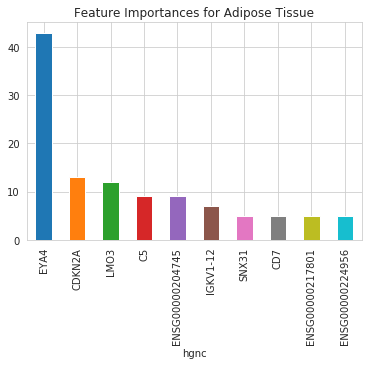

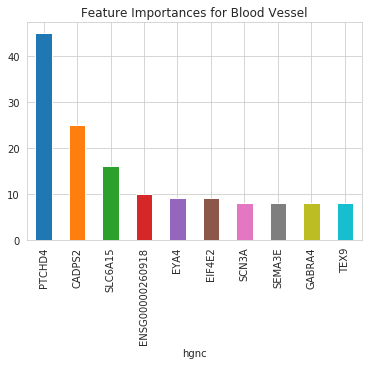

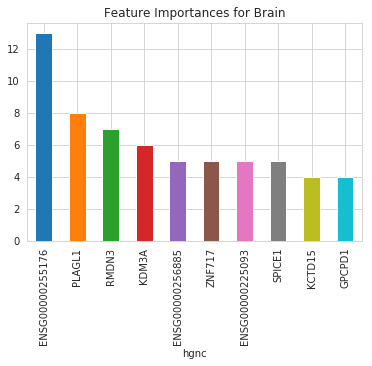

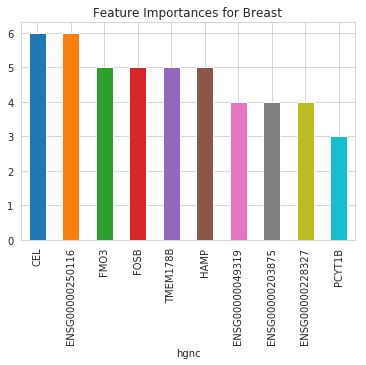

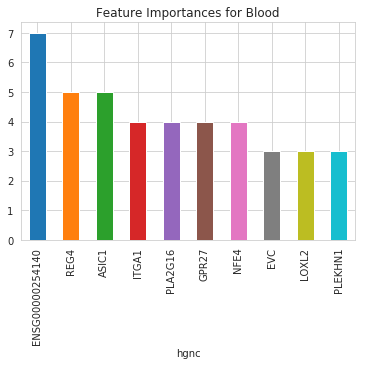

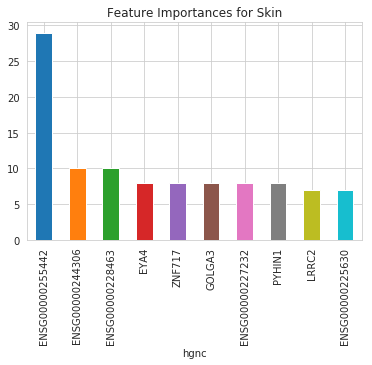

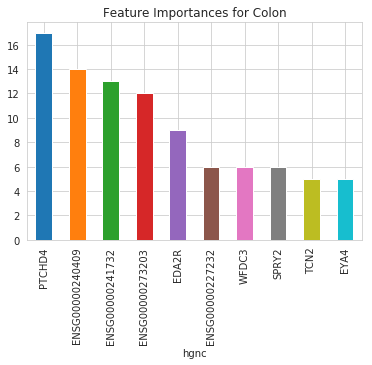

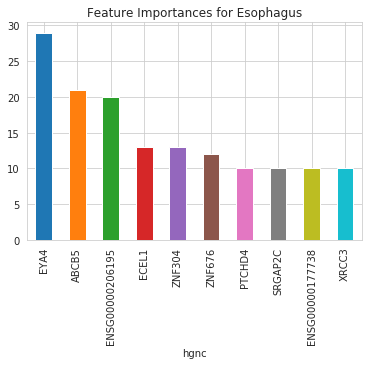

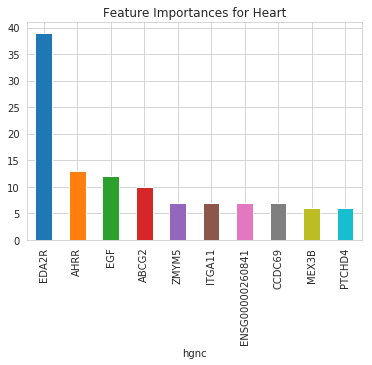

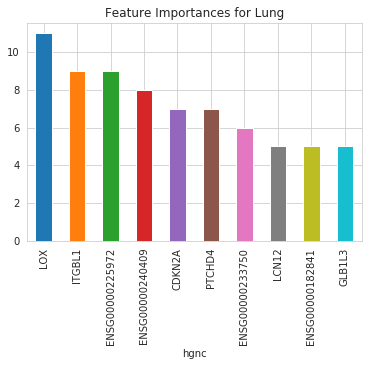

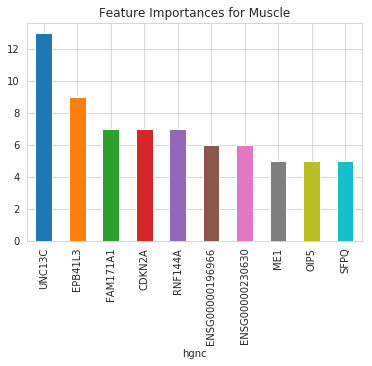

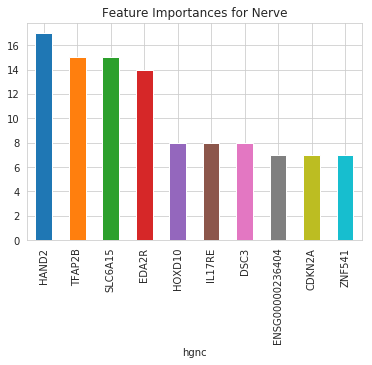

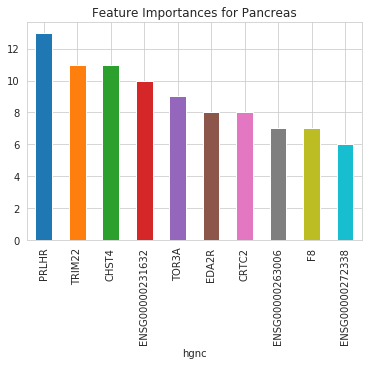

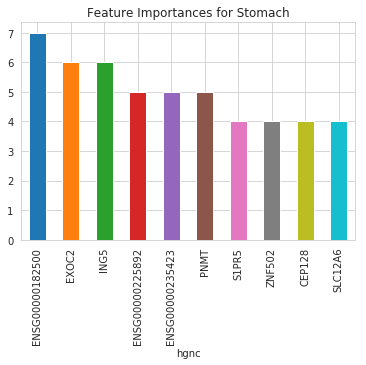

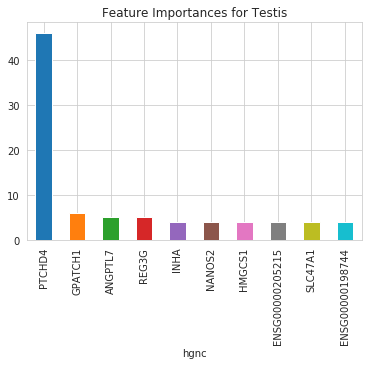

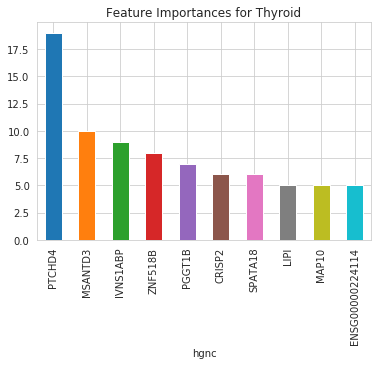

<Figure size 432x288 with 0 Axes>

In [6]:
from xgboost import plot_tree
res=[]
for x in range(len(results.index.values)):
    alg=algs[x]
    TISSUE=results.index.values[x]
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)[:200]
    feat_imp=feat_imp.to_frame('Score').join(biomart)
    sel=pd.isnull(feat_imp['hgnc'])
    feat_imp.loc[sel,"hgnc"]=feat_imp.index.values[sel]
    feat_imp=feat_imp.set_index(feat_imp['hgnc'])
    x=feat_imp['Score'][:10].plot(kind='bar', title='Feature Importances for {}'.format(TISSUE))
    #x.set_ylabel('Feature Importance Score')
    plt.show(x)
    plt.savefig(fname='plots/{}_feat_imp.png'.format(TISSUE))

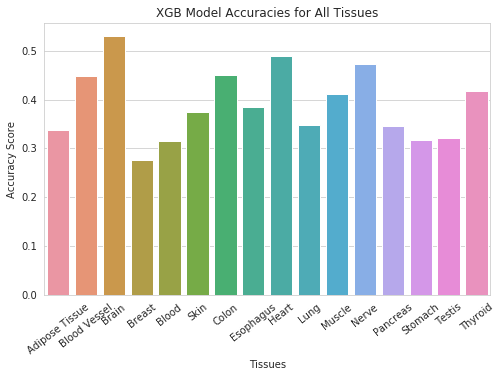

In [11]:
plt.figure(figsize=(8, 5))
ax=sns.barplot(x=results.index.values,y=results['Score'])
x=ax.set_title("XGB Model Accuracies for All Tissues")
x=ax.set_xlabel("Tissues")
x=ax.set_ylabel("Accuracy Score")
x=ax.set_xticklabels(labels=results.index.values,rotation=38)